In [11]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

In [12]:
# !curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o magic_wand_digit_data.zip
# !unzip magic_wand_digit_data.zip
# !rm -rf magic_wand_digit_data
# !mv magic_wand_digit_data-* magic_wand_digit_data
# !rm -rf magic_wand_digit_data.zip
# !rm -rf sample_data
# !mkdir -p checkpoints

In [13]:
import glob
import json

strokes = []
for filename in glob.glob("Data/wanddata_*_original.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [14]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

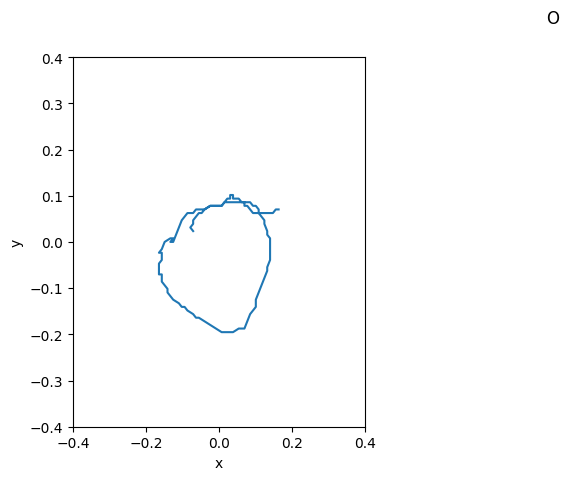

In [15]:
#for i in range(0, 900):
plot_stroke(strokes[1])

In [16]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

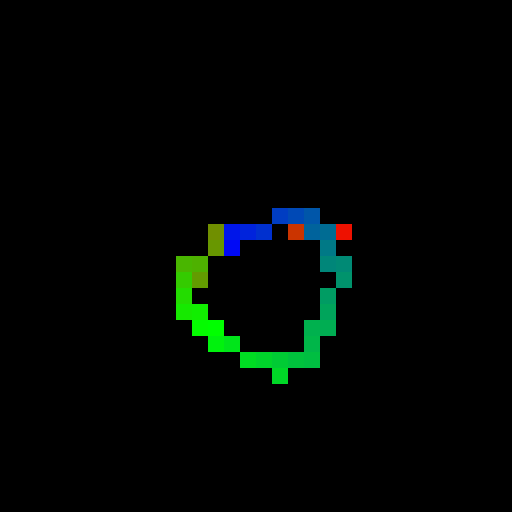

In [17]:

raster = rasterize_stroke(strokes[1]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [18]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [19]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [20]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 134 files belonging to 3 classes.
Found 11891 files belonging to 3 classes.


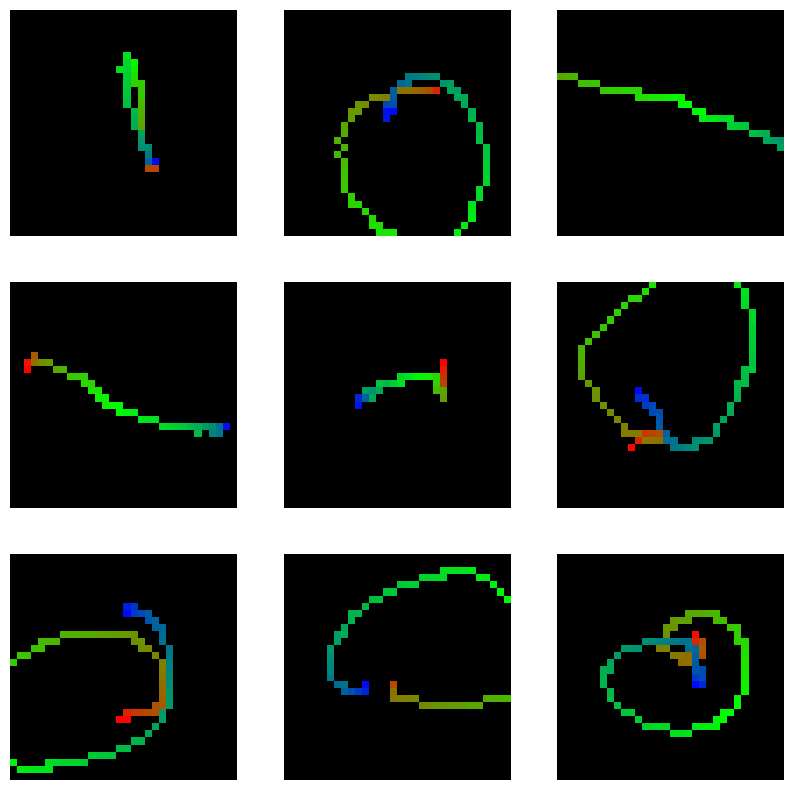

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [23]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=3)
#keras.utils.plot_model(model, show_shapes=True)

In [24]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30


371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5061 - loss: 0.6139

372/372 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5568 - loss: 0.5708 - val_accuracy: 0.4328 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 2/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6315 - loss: 0.4893

372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6502 - loss: 0.4719 - val_accuracy: 0.7985 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 3/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6992 - loss: 0.4361

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6981 - loss: 0.4319 - val_accuracy: 0.8060 - val_loss: 0.3331 - learning_rate: 0.0010
Epoch 4/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7258 - loss: 0.4056

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7232 - loss: 0.4045 - val_accuracy: 0.8284 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 5/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7448 - loss: 0.3902

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7422 - loss: 0.3875 - val_accuracy: 0.7612 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7543 - loss: 0.3739

372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7528 - loss: 0.3740 - val_accuracy: 0.9030 - val_loss: 0.2593 - learning_rate: 0.0010
Epoch 7/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7628 - loss: 0.3649

372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7602 - loss: 0.3651 - val_accuracy: 0.8731 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 8/30
365/372 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7709 - loss: 0.3576

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7732 - loss: 0.3555 - val_accuracy: 0.8433 - val_loss: 0.2941 - learning_rate: 0.0010
Epoch 9/30
368/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7779 - loss: 0.3509

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7748 - loss: 0.3518 - val_accuracy: 0.9403 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 10/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7887 - loss: 0.3402

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7774 - loss: 0.3482 - val_accuracy: 0.7910 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 11/30
365/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7953 - loss: 0.3318

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7900 - loss: 0.3365 - val_accuracy: 0.8134 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 12/30
365/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7895 - loss: 0.3388

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7868 - loss: 0.3377 - val_accuracy: 0.9254 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 13/30
365/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8036 - loss: 0.3288

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7977 - loss: 0.3310 - val_accuracy: 0.8806 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 14/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8012 - loss: 0.3289

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7988 - loss: 0.3284 - val_accuracy: 0.8209 - val_loss: 0.2994 - learning_rate: 0.0010
Epoch 15/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8056 - loss: 0.3227

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8003 - loss: 0.3263 - val_accuracy: 0.8657 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 16/30
366/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8032 - loss: 0.3182

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7994 - loss: 0.3220 - val_accuracy: 0.8657 - val_loss: 0.2577 - learning_rate: 5.0000e-04
Epoch 17/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7976 - loss: 0.3227

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8008 - loss: 0.3203 - val_accuracy: 0.8582 - val_loss: 0.2601 - learning_rate: 5.0000e-04


In [25]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)
  
index, score = predict_image(model, "test/o/4.png")

print(index, score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1 0.9744921


In [26]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.7

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = (label_dir.replace("test/", ""))
  if(label == 'test\\n'):
    label = 0
  if(label == 'test\\w'):
    label = 2
  if(label == 'test\\o'):
    label = 1
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      # print("%s expected, %d found with score %f" % (label, index, score))
      # display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [27]:
# from tinymlgen import port

# c_code = port(model, variable_name='spell_model', pretty_print=True,optimize=False)
# filename = 'net.h'
# with open(filename,'w') as f: 
#    f.write(c_code)

In [28]:
model.save(SAVED_MODEL_FILENAME+".h5")

In [29]:
#!curl -L https://storage.googleapis.com/download.tensorflow.org/models/tflite/micro/magic_wand_saved_model_2021_01_02.tgz -o saved_model.tgz
#!tar -xzf saved_model.tgz

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpi1cvm9v7\assets


INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpi1cvm9v7\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpi1cvm9v7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1879693115216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716796688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716795728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716790736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716797072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716797648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716799184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpd9dvd8ti\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpd9dvd8ti'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1879693115216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716796688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716795728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716790736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716797072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716797648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716798416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716799184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1879716

c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


30920

In [31]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [32]:
predict_tflite(model_no_quant_tflite, "test/o/2.png")

c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


(np.int64(0), np.float32(0.53192574))

In [33]:
predict_tflite(model_tflite, "test/o/2.png")

(np.int64(0), np.float32(0.5625))

In [34]:
from IPython.display import Image, display

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = (label_dir.replace("test/", ""))
  if(label == 'test\\n'):
    label = 0
  if(label == 'test\\w'):
    label = 2
  if(label == 'test\\o'):
    label = 1
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(model_tflite, filename)
    if score < 0.75:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      #print("%d expected, %d found with score %f" % (label, index, score))
      #display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

92.9% correct (N=1148, 326 unknown)


In [35]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# # Calculate size
# size_tf = get_dir_size(SAVED_MODEL_FILENAME+"h5")
# size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
# size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# # Compare size
# pd.DataFrame.from_records(
#     [["TensorFlow", f"{size_tf} bytes", ""],
#      ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
#      ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
#      columns = ["Model", "Size", ""], index="Model")


In [36]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'xxd' is not recognized as an internal or external command,
operable program or batch file.
'sed' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

'tail' is not recognized as an internal or external command,
operable program or batch file.


In [38]:
# import csv

# labells = []

# csvfile_r = open("Data/O_first_last.csv")
# csvreader_r = csv.reader(csvfile_r)
# for row in csvreader_r:
#     labells.append(row[1])

# labells.remove("last")
# csvfile_r.close()
        
# i = 0

# rows = []



# csvfile_w = open("Data/O_body_padded.csv", "r")
# csvreader_w = csv.reader(csvfile_w)
# for row in csvreader_w:
#     rows_m = []
#     for item in row:
#         rows_m.append(item)
#     rows_m.append(labells[i])
#     i += 1
#     rows.append(rows_m)

# csvfile_w.close()

# with open('Data/O_body_padded_labels.csv', 'w', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for row in rows:
#         spamwriter.writerow(row)
